## 用于生成 “标准化” 数据来训练 PSO
原数据见： gen_train_data.ipynb

In [56]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
from shapely import Point, LineString, Polygon
import ast
from CPP_Planner import CPP_Planner_Kit
from rasterio.mask import mask

### 读取所有数据

In [71]:
# dem_src = rasterio.open('GIS_data/路径规划优化用数据/2m_pClouds_regen_dem_cm.tif')
# aspect_src = rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_cm1.tif')
aspect_src = rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_21.tif')
# slope_src = rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif')
# curvature_src = rasterio.open('GIS_data/路径规划优化用数据/Curvatu_clip_pcGen_2m_cm1.tif')

dem_src = rasterio.open(r'GIS_data/路径规划优化用数据/halfM_tifs/dem_halfM_clip1.tif')
# aspect_src = rasterio.open(r'GIS_data/路径规划优化用数据/halfM_tifs/Aspect_halfM_clip1.tif')
slope_src = rasterio.open(r'GIS_data/路径规划优化用数据/halfM_tifs/Slope_clip_halfM1.tif')
curvature_src = rasterio.open(r'GIS_data/路径规划优化用数据/halfM_tifs/Curvatu_halfM_clip1.tif')


dem_array = dem_src.read(1)
aspect_array = aspect_src.read(1)
slope_array = slope_src.read(1)
curvature_array = curvature_src.read(1)

straight_swaths = gpd.read_file('GIS_data/路径规划优化用数据/all_swaths/all_straight_swaths_group.shp')
real_swaths = gpd.read_file('GIS_data/路径规划优化用数据/all_swaths/all_swaths_group.shp')
# all_land = gpd.read_file('../Scratch/test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
all_land = gpd.read_file('GIS_data/路径规划优化用数据/seperate_land_0.shp')

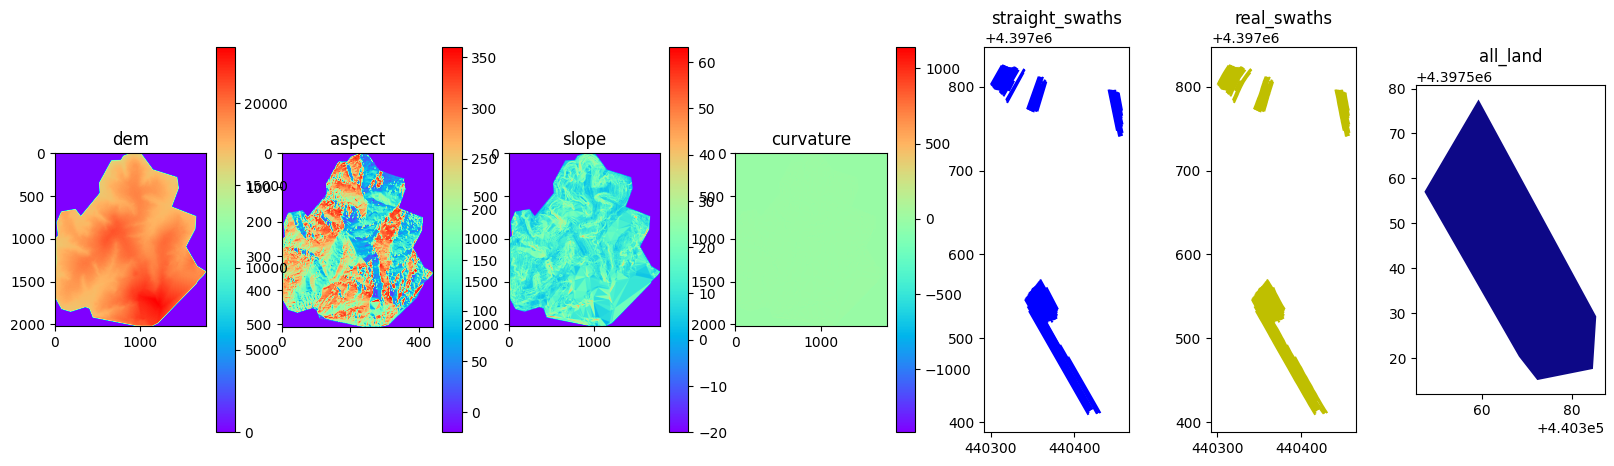

In [72]:
# 预处理，设置NODATA为特殊的值
NODATA = -20
# dem_array[dem_array == dem_array.min()] = NODATA
dem_array[dem_array == dem_array.max()] = NODATA
aspect_array[aspect_array == aspect_array.min()] = NODATA
slope_array[slope_array == slope_array.min()] = NODATA
curvature_array[curvature_array == curvature_array.min()] = NODATA

# all_land = CPP_Planner_Kit.get_single_shp(all_land, 4)

# show
_, axes = plt.subplots(ncols=7, nrows=1, dpi=100, figsize=(20, 5))
# set title
axes[0].set_title('dem')
axes[1].set_title('aspect')
axes[2].set_title('slope')
axes[3].set_title('curvature')
axes[4].set_title('straight_swaths')
axes[5].set_title('real_swaths')
axes[6].set_title('all_land')

im = axes[0].imshow(dem_array, cmap='rainbow')
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(aspect_array, cmap='rainbow')
plt.colorbar(im, ax=axes[1])
im = axes[2].imshow(slope_array, cmap='rainbow')
plt.colorbar(im, ax=axes[2])
im = axes[3].imshow(curvature_array, cmap='rainbow')
plt.colorbar(im, ax=axes[3])
straight_swaths.plot(ax=axes[4], color='b')
real_swaths.plot(ax=axes[5], color='y')
# make all land only one seperate land
all_land = gpd.GeoDataFrame(geometry=[all_land.geometry[0]], crs=all_land.crs)
all_land.plot(ax=axes[6], cmap='plasma')

# 决定是否使用 道格拉斯普克 简化真实曲线
straight_swaths = []
for temp_line in real_swaths.geometry:
    temp_simplified_line = temp_line.simplify(0.5, preserve_topology=False)
    straight_swaths.append(temp_simplified_line)
straight_swaths = gpd.GeoDataFrame(geometry=straight_swaths, crs=real_swaths.crs)

### 以每一个地块为单位，裁剪 slope, aspect, curvature, dem，并计算每个地块上的平均值，每一个相元减去平均值取绝对值，得到标准化的数据

In [59]:
# hard-code 各个列表
# swath_sep_indxes = [0, 28, 39, 49, 71]
# useful_land_indexes = [0, 4, 5, 6]
# 使用 seperate 时，留意索引
# useful_land_indexes = [0, 1]
# useful_land_indexes = [0, 1]
# swath_sep_indxes = [0, 11, 27]
# 使用单独的 land 时候，使用这个
# useful_land_indexes = [1]
# swath_sep_indxes = [28, 40]
useful_land_indexes = [0]
swath_sep_indxes = [11, 27]
print(useful_land_indexes)
all_land

[0]


,geometry
0,"POLYGON ((440372.292 4397515.052, 440368.196 4..."


In [60]:
# 用于保存各个地块上 slope 的 mean、min
land_mean_min = []  # [ (mean1, min1, median1), (mean2, min2, median2)...]
for i, temp_land_ind in enumerate(useful_land_indexes):
    temp_land = CPP_Planner_Kit.get_single_shp(all_land, temp_land_ind)
    temp_land_geom = temp_land.geometry.values.tolist()
    temp_land_raster, temp_raster_tran = mask(slope_src, temp_land_geom, crop=True)
    temp_mean = np.mean(temp_land_raster[temp_land_raster != temp_land_raster.min()])
    temp_min = np.min(temp_land_raster[temp_land_raster != temp_land_raster.min()])
    temp_median = np.median(temp_land_raster[temp_land_raster != temp_land_raster.min()])
    land_mean_min.append((temp_mean, temp_min, temp_median))
print('Mean Averages: ')
print(land_mean_min)

Mean Averages: 
[(12.472557, 0.20257033, 11.9395075)]


### 采样数据

In [61]:
# data = pd.DataFrame(columns=['origin_x', 'origin_y', 'height', 'aspect', 'slope'])
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
    CURVATURE = 4
# ------------------------------ 
def sample_point_from_raster(point: Point, category):
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    elif category == raster.CURVATURE:
        temp_raster = curvature_array
        temp_src = curvature_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    return temp_raster[row, col]

### 按照不同地块来采样，注意相减的平均/最小坡度
* 平均值、最小值、中位数的索引分别为 0、1、2

In [62]:
# 数据采集的精度，单位 m
step_length = 1  # (m)
all_sample_points = []
all_real_swath_index = []
all_data_group = []
for i, group_ind in enumerate(swath_sep_indxes[: 1]):  # swath_sep_indxes[:2]
    # print(group_ind, swath_sep_indxes[i + 1])
    print('ind: ', i)
    temp_mean, temp_min = land_mean_min[i][0], land_mean_min[i][1]
    temp_swath_group = straight_swaths[group_ind:swath_sep_indxes[i + 1]]
    # 对当前的 swath group 内采样
    temp_sample_group = []
    temp_real_swath_index = []
    # 获取采样的点位
    for j, single_straight_swath in enumerate(temp_swath_group.geometry):
        temp_sample_points = np.arange(0, single_straight_swath.length, step_length)
        temp_sample_group += [single_straight_swath.interpolate(temp_sample_point) for temp_sample_point in temp_sample_points]
        # 这里的 j 仅仅只是当前 temp_swath_group 内的索引，还需要加上当前 group 的起始位置 group_ind
        temp_real_swath_index += [j + group_ind for x in range(len(temp_sample_points))]
    # 对当前 group 内的点进行采样
    temp_data_group = []
    for temp_sample_point, temp_sample_line_index in zip(temp_sample_group, temp_real_swath_index):
        new_row = [
            temp_sample_point.x, temp_sample_point.y,
            sample_point_from_raster(temp_sample_point, category=raster.DEM),
            sample_point_from_raster(temp_sample_point, category=raster.ASPECT),
            # 如果需要 normalize，那么减去一个 mean 或是 min，索引分别是 0 1
            sample_point_from_raster(temp_sample_point, category=raster.SLOPE),
            # abs(sample_point_from_raster(temp_sample_point, category=raster.SLOPE) - land_mean_min[i][2]),
            sample_point_from_raster(temp_sample_point, category=raster.CURVATURE),
            temp_sample_line_index
        ]
        temp_data_group.append(new_row)
    # 将当前所有的数据保存起来
    all_data_group += temp_data_group
all_data_group = pd.DataFrame(columns=['origin_x', 'origin_y', 'height', 'aspect', 'slope', 'curvature', 'label'], data=all_data_group)
print(len(all_data_group))

ind:  0
759


In [63]:
all_data_group

,origin_x,origin_y,height,aspect,slope,curvature,label
0,440368.290474,4.397521e+06,20356,152.525574,11.933021,16.009521,11
1,440367.797278,4.397522e+06,20373,210.068588,9.350349,16.003418,11
2,440367.304081,4.397523e+06,20374,204.044220,10.089585,-8.007812,11
3,440366.810885,4.397524e+06,20402,159.623566,10.574347,91.992188,11
4,440366.317689,4.397525e+06,20399,13.671307,5.438008,31.994629,11
...,...,...,...,...,...,...,...
754,440427.056295,4.397415e+06,20006,83.290161,4.891808,-4.003906,26
755,440427.579949,4.397414e+06,20005,23.198589,2.180705,-47.985840,26
756,440428.103602,4.397413e+06,20009,344.744873,3.262830,-47.998047,26
757,440428.627256,4.397412e+06,20021,68.198593,1.542363,59.997559,26


In [64]:
# all_data_group.to_csv('1m_preci_sample_DASC_all_land.csv', index=False)
# all_data_group.to_csv('norm_mean_1m_preci_sample_DASC_sep_land_1.csv', index=False)
# all_data_group.to_csv('norm_median_1m_preci_sample_DASC_sep_land_2.csv', index=False)
# all_data_group.to_csv('norm_mean_simp_1m_preci_sample_DASC_sep_land.csv', index=False)
# all_data_group.to_csv('exhalf_median_1m_preci_sample_DASC_sep_land_0.csv', index=False)
all_data_group.to_csv('exhalf_only_small_1m_preci_sample_DASC_sep_land_0_0.csv', index=False)


### 保存

In [65]:
straight_swaths

,geometry
0,"LINESTRING (440345.934 4397532.698, 440416.734..."
1,"LINESTRING (440344.259 4397538.164, 440417.068..."
2,"LINESTRING (440417.124 4397412.820, 440378.040..."
3,"LINESTRING (440341.767 4397547.859, 440392.103..."
4,"LINESTRING (440419.076 4397414.652, 440394.099..."
...,...
66,"LINESTRING (440318.724 4397824.400, 440308.971..."
67,"LINESTRING (440317.685 4397825.209, 440310.010..."
68,"LINESTRING (440316.526 4397825.756, 440306.685..."
69,"LINESTRING (440315.313 4397826.171, 440306.456..."


IndexError: single positional indexer is out-of-bounds

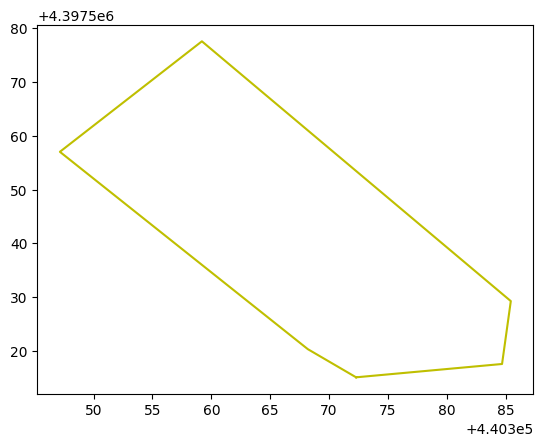

In [66]:
_, ax = plt.subplots()
ax.plot(*all_land.geometry.iloc[0].exterior.xy, c='y')
ax.plot(*all_land.geometry.iloc[1].exterior.xy, c='b')
ax.set_aspect('equal')